In [44]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

In [45]:
c1 = 0.4
c2 = 0.6

T21 = 45
T22_ill = 60
T22_well = 100

iterations = 10000

SNR_fixed = 500

init_p = [0.5,0.5, 50,55]

lb = [0,0,5,25]
ub = [1,1,100,200]

TE_series = np.linspace(8, 512, 64) #ms units

In [46]:
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def add_noise(data, SNR):
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    return data + noise

def set_p0(lb, ub, random = True):

    p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
            
    return p0

def check_param_order(popt):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[2] > popt[3]): #We want by convention to make sure that T21 is <= T22
        p_hold = popt[0]
        popt[0] = popt[1]
        popt[1] = p_hold

        p_hold = popt[2]
        popt[2] = popt[3]
        popt[3] = p_hold
    return popt

def estimate_NLLS(function, tdata, data, lb, ub):

    init_p = set_p0(lb, ub)
    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    f_name = function.__name__
    if f_name != "S_moX_2p":
        popt = check_param_order(popt)
        
    return popt


In [47]:
### All code associated with the ill-posed case

sig_stand_ill = S_biX_4p(TE_series, c1, c2, T21, T22_ill)
sig_noise_ill = add_noise(sig_stand_ill, SNR_fixed)

param_combos_ill = np.zeros((iterations, 4))

for iter in trange(iterations):
    np.random.seed(iter)
    param_est = estimate_NLLS(S_biX_4p, TE_series, sig_noise_ill, lb, ub)
    param_combos_ill[iter, :] = param_est

100%|██████████| 10000/10000 [03:54<00:00, 42.65it/s]


In [48]:
sig_stand_well = S_biX_4p(TE_series, c1, c2, T21, T22_well)
sig_noise_well = add_noise(sig_stand_well, SNR_fixed)

param_combos_well = np.zeros((iterations, 4))

for iter in trange(iterations):
    np.random.seed(iter)
    param_est = estimate_NLLS(S_biX_4p, TE_series, sig_noise_well, lb, ub)
    param_combos_well[iter, :] = param_est

100%|██████████| 10000/10000 [01:51<00:00, 89.98it/s]


In [49]:
sig_stand_mono = S_moX_2p(TE_series, c1, T21)
sig_noise_mono = add_noise(sig_stand_mono, SNR_fixed)

param_combos_mono = np.zeros((iterations, 2))

lb_moX = [lb[0], lb[2]]
ub_moX = [ub[0], ub[2]]

for iter in trange(iterations):
    np.random.seed(iter)
    param_est = estimate_NLLS(S_moX_2p, TE_series, sig_noise_mono, lb_moX, ub_moX)
    param_combos_mono[iter, :] = param_est

100%|██████████| 10000/10000 [00:45<00:00, 219.58it/s]


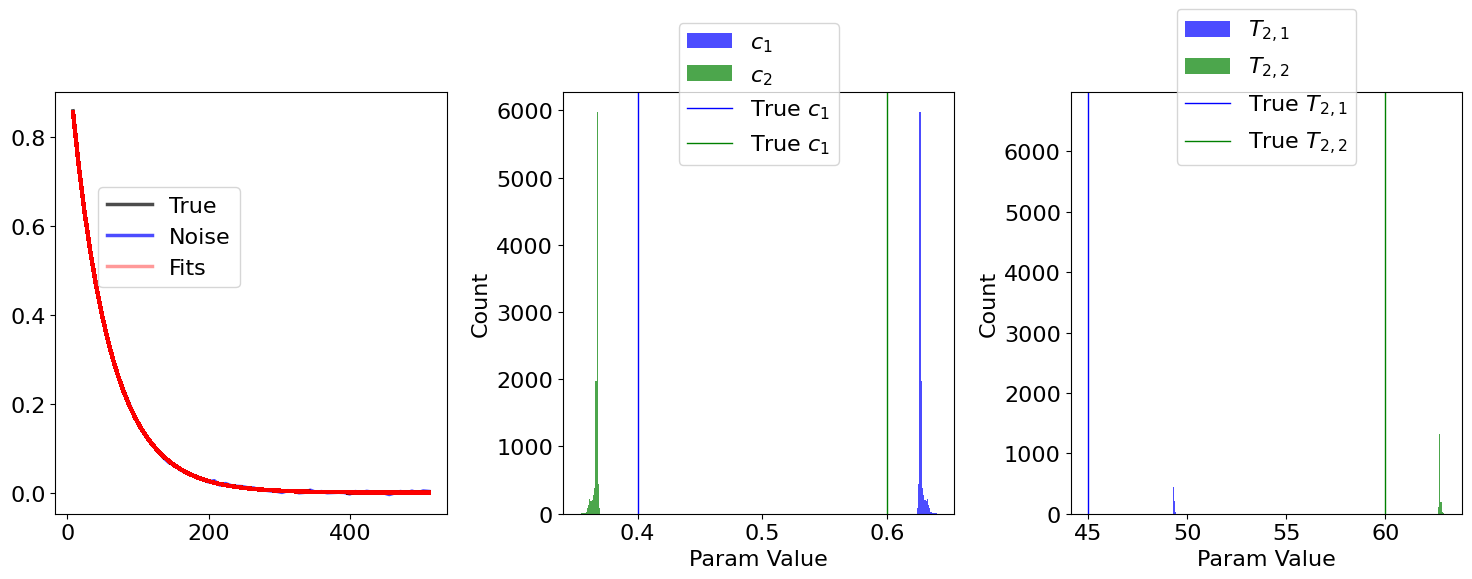

In [50]:
fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

plt.rc('font', size = 16)

ax[0].plot(TE_series, sig_stand_ill, label = 'True', alpha = 0.7, ls = '-', lw = 2.5, color = 'k')
ax[0].plot(TE_series, sig_noise_ill, label = 'Noise', alpha = 0.7, ls = '-', lw = 2.5, color = 'b')
for iter in range(iterations):
    ax[0].plot(TE_series, S_biX_4p(TE_series, *param_combos_ill[iter,:]), label = 'Fits', alpha = 0.4, ls = '-', lw = 2.5, color = 'r')

handler_curve, labeler_curve = ax[0].get_legend_handles_labels()
hd = handler_curve[0:3]
lab = labeler_curve[0:3]
ax[0].legend(hd, lab, bbox_to_anchor = [0.5,0.8])

ax[1].hist(x=param_combos_ill[:,0], bins=20, color='b', label = r'$c_1$', alpha = 0.7)
ax[1].hist(x=param_combos_ill[:,1], bins=20, color='g', label = r'$c_2$', alpha = 0.7)
ax[1].set_xlabel('Param Value')
ax[1].set_ylabel('Count')
ax[1].axvline(x=c1, linewidth=1, label= r'True $c_1$', color='b')
ax[1].axvline(x=c2, linewidth=1, label= r'True $c_1$', color='g')
ax[1].legend(bbox_to_anchor = [0.5,0.8])

ax[2].hist(x=param_combos_ill[:,2], bins=20, color='b', label = r'$T_{2,1}$', alpha = 0.7)
ax[2].hist(x=param_combos_ill[:,3], bins=20, color='g', label = r'$T_{2,2}$', alpha = 0.7)
ax[2].set_xlabel('Param Value')
ax[2].set_ylabel('Count')
ax[2].axvline(x=T21, linewidth=1, label= r'True $T_{2,1}$', color='b')
ax[2].axvline(x=T22_ill, linewidth=1, label= r'True $T_{2,2}$', color='g')
ax[2].legend(bbox_to_anchor = [0.5,0.8])

plt.show()

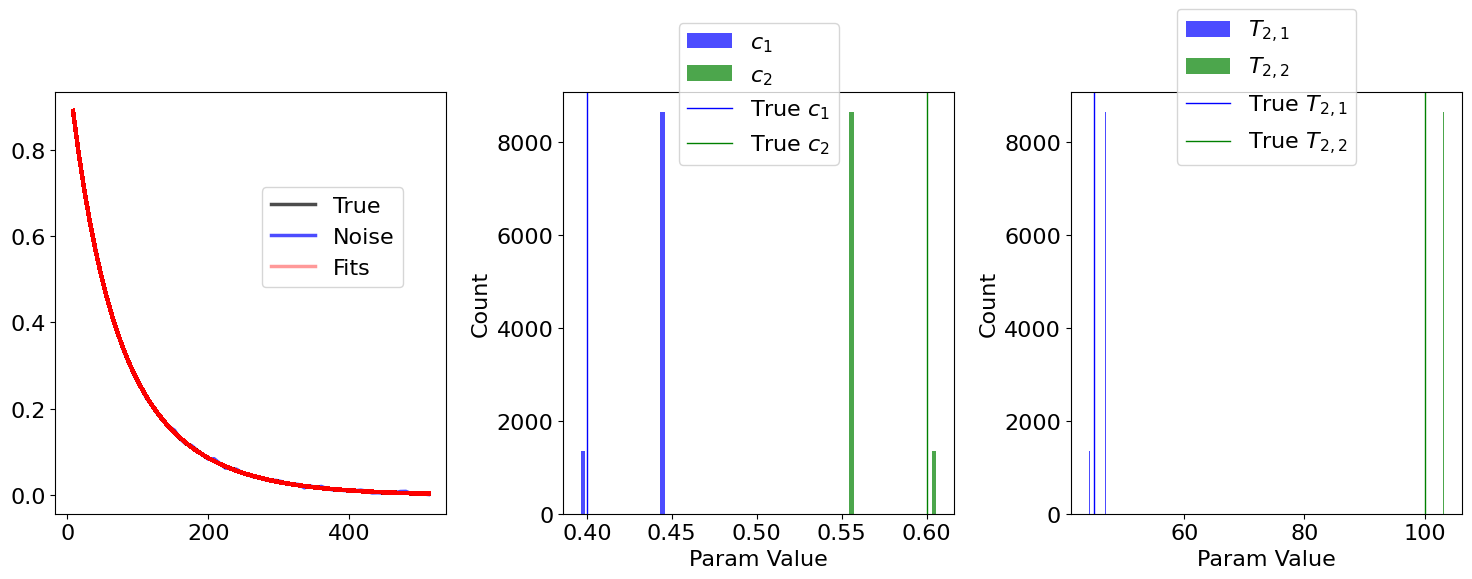

In [51]:
fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

plt.rc('font', size = 16)

ax[0].plot(TE_series, sig_stand_well, label = 'True', alpha = 0.7, ls = '-', lw = 2.5, color = 'k')
ax[0].plot(TE_series, sig_noise_well, label = 'Noise', alpha = 0.7, ls = '-', lw = 2.5, color = 'b')
for iter in range(iterations):
    ax[0].plot(TE_series, S_biX_4p(TE_series, *param_combos_well[iter,:]), label = 'Fits', alpha = 0.4, ls = '-', lw = 2.5, color = 'r')

handler_curve, labeler_curve = ax[0].get_legend_handles_labels()
hd = handler_curve[0:3]
lab = labeler_curve[0:3]
ax[0].legend(hd, lab, bbox_to_anchor = [0.5,0.8])

ax[1].hist(x=param_combos_well[:,0], bins=20, color='b', label = r'$c_1$', alpha = 0.7)
ax[1].hist(x=param_combos_well[:,1], bins=20, color='g', label = r'$c_2$', alpha = 0.7)
ax[1].set_xlabel('Param Value')
ax[1].set_ylabel('Count')
ax[1].axvline(x=c1, linewidth=1, label= r'True $c_1$', color='b')
ax[1].axvline(x=c2, linewidth=1, label= r'True $c_2$', color='g')
ax[1].legend(bbox_to_anchor = [0.5,0.8])

ax[2].hist(x=param_combos_well[:,2], bins=20, color='b', label = r'$T_{2,1}$', alpha = 0.7)
ax[2].hist(x=param_combos_well[:,3], bins=20, color='g', label = r'$T_{2,2}$', alpha = 0.7)
ax[2].set_xlabel('Param Value')
ax[2].set_ylabel('Count')
ax[2].axvline(x=T21, linewidth=1, label= r'True $T_{2,1}$', color='b')
ax[2].axvline(x=T22_well, linewidth=1, label= r'True $T_{2,2}$', color='g')
ax[2].legend(bbox_to_anchor = [0.5,0.8])

plt.show()

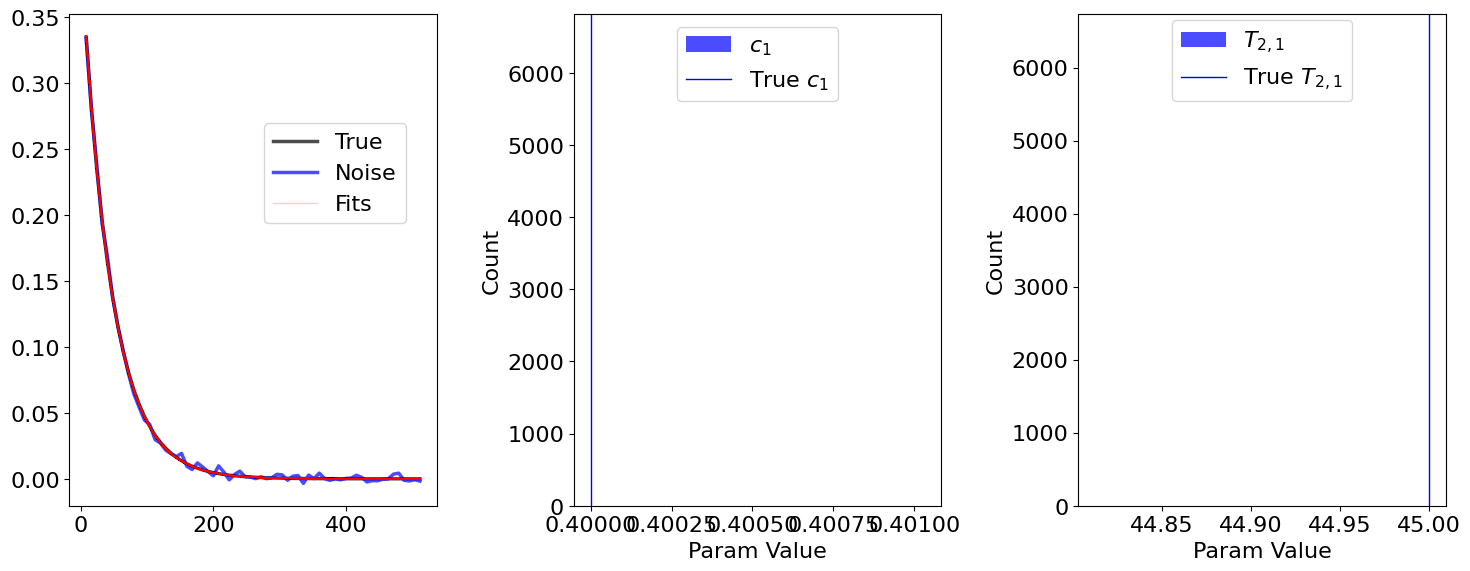

In [52]:
fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

plt.rc('font', size = 16)

ax[0].plot(TE_series, sig_stand_mono, label = 'True', alpha = 0.7, ls = '-', lw = 2.5, color = 'k')
ax[0].plot(TE_series, sig_noise_mono, label = 'Noise', alpha = 0.7, ls = '-', lw = 2.5, color = 'b')
for iter in range(iterations):
    ax[0].plot(TE_series, S_moX_2p(TE_series, *param_combos_mono[iter,:]), label = 'Fits', alpha = 0.2, ls = '-', lw = 1, color = 'r')

handler_curve, labeler_curve = ax[0].get_legend_handles_labels()
hd = handler_curve[0:3]
lab = labeler_curve[0:3]
ax[0].legend(hd, lab, bbox_to_anchor = [0.5,0.8])

ax[1].hist(x=param_combos_mono[:,0], bins=20, color='b', label = r'$c_1$', alpha = 0.7)
ax[1].set_xlabel('Param Value')
ax[1].set_ylabel('Count')
ax[1].axvline(x=c1, linewidth=1, label= r'True $c_1$', color='b')
ax[1].legend(bbox_to_anchor = [0.5,0.8])

ax[2].hist(x=param_combos_mono[:,1], bins=20, color='b', label = r'$T_{2,1}$', alpha = 0.7)
ax[2].set_xlabel('Param Value')
ax[2].set_ylabel('Count')
ax[2].axvline(x=T21, linewidth=1, label= r'True $T_{2,1}$', color='b')
ax[2].legend(bbox_to_anchor = [0.5,0.8])

plt.show()